In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary
torch.set_printoptions(sci_mode=False)

In [18]:
PATH = Path("/home/rob/code/Project/dataset/GTSRB/Training")
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [19]:
_N = 32
batch_size = 128
n_classes = 43
epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale()
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = 0
    std = 0
    total = 0
    for images,_ in dataloader: # load a batch at a time
        total += 1
        mean  += images.mean()
        std   += images.std()
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor(0.3211), tensor(0.2230))

In [21]:
mean = 0.3211
std = 0.2230

def to_image(img): # convert to unormalized form for viewing

    return (img * std + mean).permute(1,2,0).numpy()

normalise = transforms.Normalize(mean, std)
transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    normalise
])

In [22]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

torch.Size([128, 1, 32, 32])
No passing


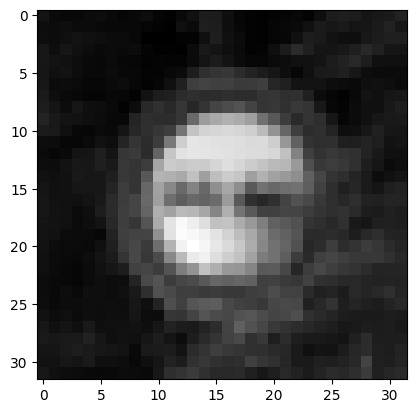

In [23]:
for img,label in train_loader:
    print(img.shape)
    img = to_image(img[0])

    plt.imshow(img,cmap="grey")
    print(LABELS[label[0]])
    break

In [30]:
class SoftModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((64,1,_N,_N))

        self.activation = torch.nn.functional.relu

        self.pool = torch.nn.AvgPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(1,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],128)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],64)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)
        self.softmax = torch.nn.Softmax(dim=1)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return self.softmax(x)
        
model = SoftModel().to(device)
summary(model,(1,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 6, 28, 28]             156
         AvgPool2d-2           [128, 6, 14, 14]               0
            Conv2d-3          [128, 16, 10, 10]           2,416
         AvgPool2d-4            [128, 16, 5, 5]               0
            Linear-5                 [128, 128]          51,328
            Linear-6                  [128, 64]           8,256
            Linear-7                  [128, 43]           2,795
           Softmax-8                  [128, 43]               0
Total params: 64,951
Trainable params: 64,951
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 7.97
Params size (MB): 0.25
Estimated Total Size (MB): 8.71
----------------------------------------------------------------


In [33]:
for img,label in train_loader:
    img = img.to(device)
    pred = model(img)
    print(pred.shape)
    print(pred[0])
    print(torch.sum(pred[0]))
    break

torch.Size([128, 43])
tensor([0.0213, 0.0217, 0.0224, 0.0253, 0.0238, 0.0213, 0.0226, 0.0213, 0.0253,
        0.0253, 0.0247, 0.0253, 0.0253, 0.0221, 0.0221, 0.0256, 0.0227, 0.0212,
        0.0247, 0.0221, 0.0237, 0.0217, 0.0210, 0.0218, 0.0232, 0.0212, 0.0219,
        0.0216, 0.0204, 0.0255, 0.0249, 0.0235, 0.0225, 0.0241, 0.0231, 0.0243,
        0.0254, 0.0240, 0.0250, 0.0219, 0.0232, 0.0246, 0.0253],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)


In [34]:
assert False

AssertionError: 

In [25]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [26]:

def train(model,loss_func,optimiser):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")

def test_performance(model,loss_func):
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            loss += loss_func(preds,labels).item()
    return loss / len(test_loader)

In [12]:
train(model,loss_func,optimiser)

Epoch 1 --- Training Loss 3.717 --- Validation Loss 3.700
Epoch 2 --- Training Loss 3.641 --- Validation Loss 3.564
Epoch 3 --- Training Loss 3.496 --- Validation Loss 3.462
Epoch 4 --- Training Loss 3.455 --- Validation Loss 3.452
Epoch 5 --- Training Loss 3.451 --- Validation Loss 3.448
Epoch 6 --- Training Loss 3.443 --- Validation Loss 3.427
Epoch 7 --- Training Loss 3.415 --- Validation Loss 3.415
Epoch 8 --- Training Loss 3.412 --- Validation Loss 3.413
Epoch 9 --- Training Loss 3.410 --- Validation Loss 3.412
Epoch 10 --- Training Loss 3.408 --- Validation Loss 3.410
Epoch 11 --- Training Loss 3.403 --- Validation Loss 3.390
Epoch 12 --- Training Loss 3.360 --- Validation Loss 3.352
Epoch 13 --- Training Loss 3.344 --- Validation Loss 3.349
Epoch 14 --- Training Loss 3.341 --- Validation Loss 3.346
Epoch 15 --- Training Loss 3.341 --- Validation Loss 3.345
Epoch 16 --- Training Loss 3.339 --- Validation Loss 3.332
Epoch 17 --- Training Loss 3.309 --- Validation Loss 3.287
Epoch 

In [13]:
def evaluate(model):
    predictions = []
    labels = []
    with torch.no_grad():
        for images,lbls in test_loader:
            labels.extend(lbls.numpy())
            
            images = images.to(device)
            preds = model(images)
            predictions.extend(preds.cpu().numpy())
            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')
evaluate(model)

Precision (macro): 0.3861
Recall (macro): 0.5677
F1-score (macro): 0.4445


/home/rob/code/Project/pytorchenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
@torch.compile
def pgd_attack(model,images,labels,loss_func,iterations,epsilon,alpha):
    
    adversarial = denormalise(images)
    lower_bound = adversarial - epsilon
    upper_bound = adversarial + epsilon
    
    decay = torch.logspace(alpha,1,iterations,2)
    decay = decay / decay[0]

    for alpha in decay:
        normalised = normalise(adversarial)
        normalised.requires_grad = True
        model.zero_grad()
        pred = model(normalised)
        loss = loss_func(pred,labels)
        #print(loss.item())
        loss.backward()
        # TODO - Edit Learning Rate / Apply Adam Optimiser
        perturbations = torch.sign(normalised.grad.data) * epsilon * alpha
        adversarial += perturbations
        adversarial = torch.clip(adversarial,lower_bound, upper_bound)
        adversarial = torch.clip(adversarial,0,1)

    return normalise(adversarial)


normalise.to(device)

@torch.compile
def denormalise(images):
    return images * std + mean

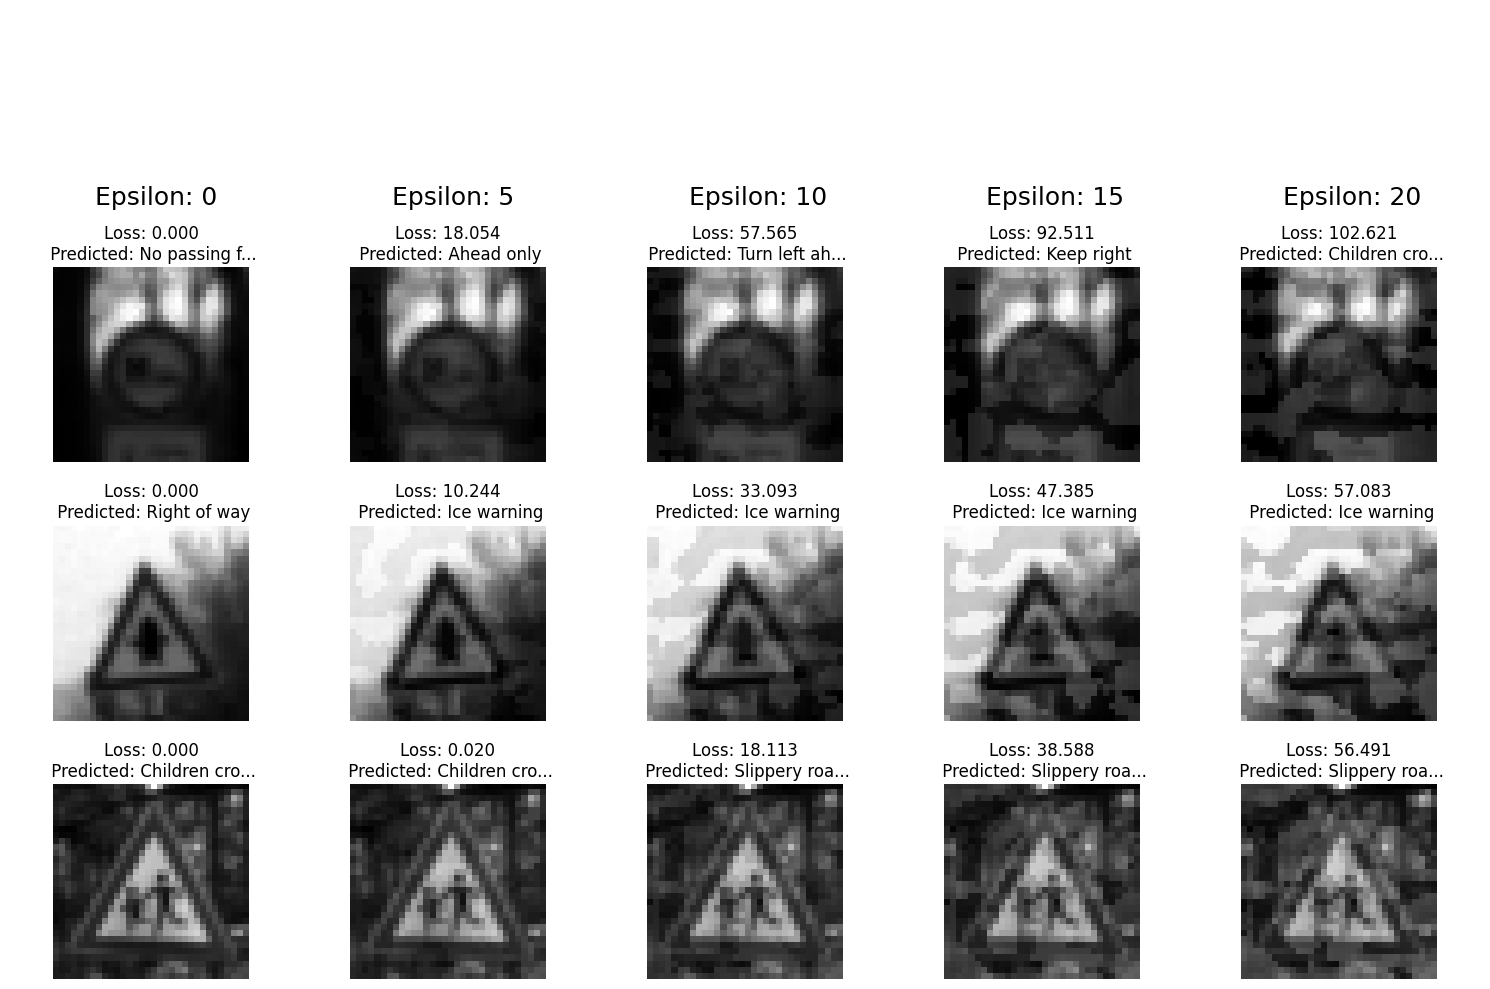

In [71]:
def adversarial_test(model):
    for img,lbl in test_loader:
        img = img.to(device)
        lbl = lbl.to(device)

        """og_pred = model(img)
        adv_pred = model(adv)
        og_loss = loss_func()"""
        #print(f"Set: {epsilon}\nActual: {torch.max(denormalise(img)-denormalise(adv))}")

        rows = 4
        columns = 5
        
        plt.figure(figsize=(15, 10))
        multiplier = 5
        for j in range(columns):
            epsilon = j * multiplier
            plt.subplot(rows, columns, j + 1)
            plt.axis("off")
            plt.text(0.3, 0, f"Epsilon: {epsilon}", fontsize=18)

            

        for j in range(columns):
            epsilon = j * multiplier / 255
            adv = pgd_attack(model,img,lbl,loss_func,50,epsilon,2)
            for i in range(1,rows):
                plt.subplot(rows, columns, i * columns + j + 1)
                pred = model(adv[i].reshape(1,1,_N,_N))
                loss = loss_func(pred,lbl[i].reshape(1)).data
                pred_class = LABELS[torch.argmax(pred)]
                pred_class = pred_class[:12] + "..." if len(pred_class) > 12 else pred_class
                plt.imshow(to_image(adv[i].cpu()),cmap="grey")
                plt.title(f"Loss: {loss:.3f}\n Predicted: {pred_class}")
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        # Gets errors for images being out of 0-1 range, probably floating point inaccuracy
        break
adversarial_test(model)

In [72]:
def adversarial_training(model,loss_func,optimiser,epochs,iterations,epsilon,alpha):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            images = torch.cat((images,
                pgd_attack(model,images,labels,loss_func,iterations,epsilon,alpha)
                ))
            labels = torch.cat((labels,labels))

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")


In [14]:
adversarial_model = model
adv_optimiser = torch.optim.Adam(adversarial_model.parameters())#torch.optim.SGD(adversarial_model.parameters(),lr=0.01, momentum=0.9)

In [15]:
epochs = 30
alpha = 2
iterations = 20
epsilon = 10 / 255
adversarial_training(adversarial_model,loss_func,adv_optimiser,epochs,iterations,epsilon,alpha) # 20 mins -> 60 epochs

NameError: name 'adversarial_training' is not defined

In [75]:
evaluate(adversarial_model)

Precision (macro): 0.9124
Recall (macro): 0.8943
F1-score (macro): 0.8980


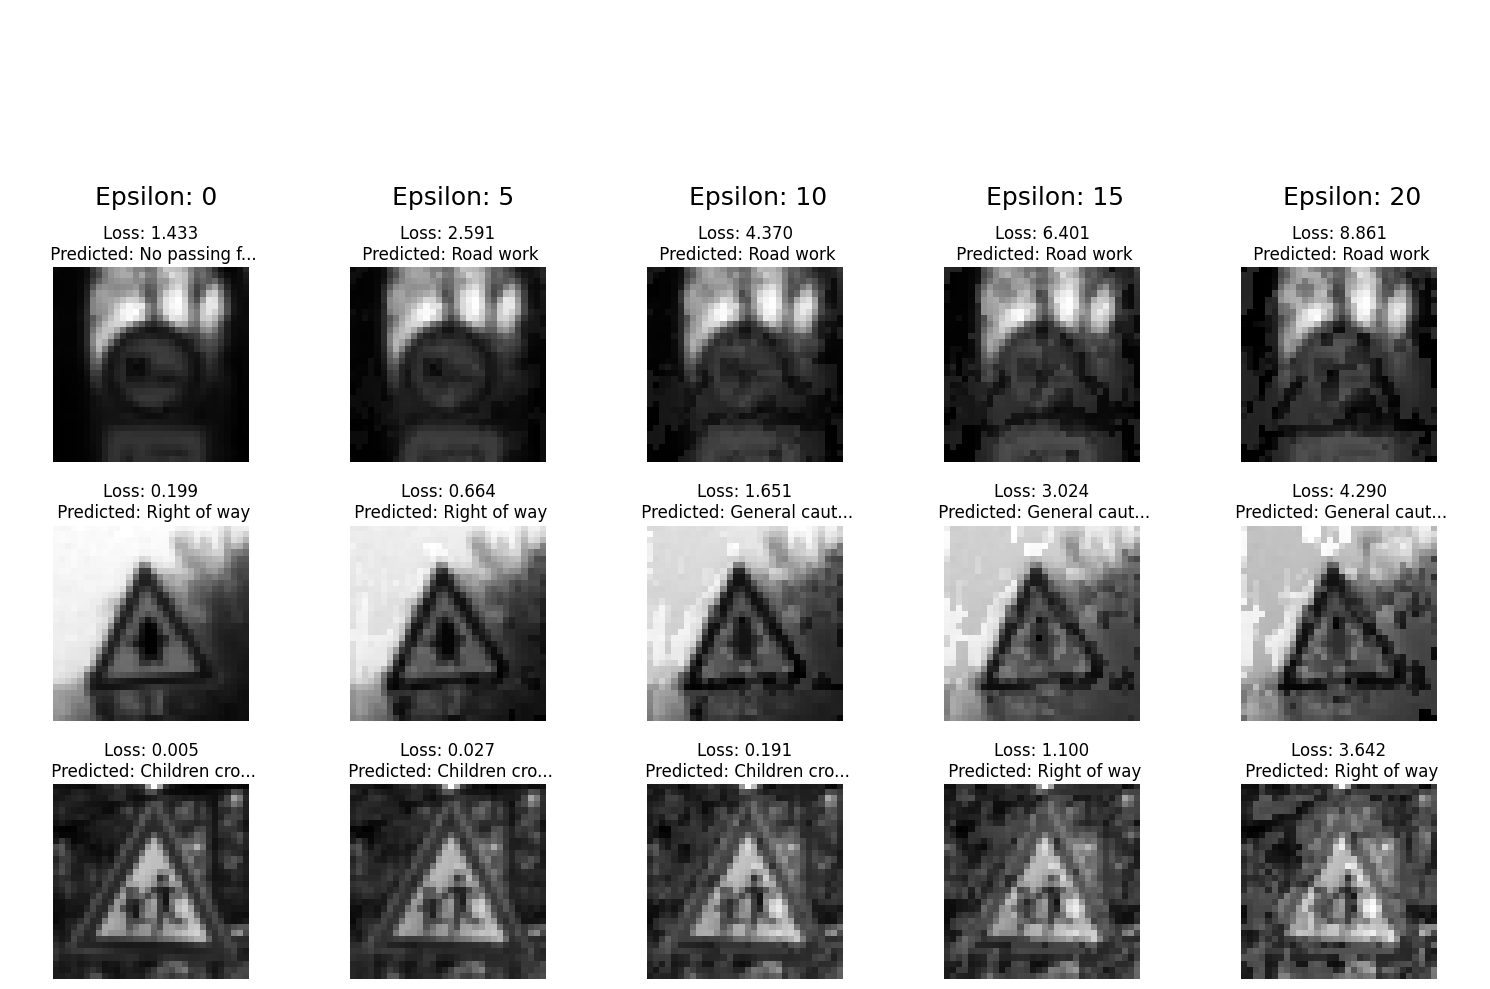

In [76]:
adversarial_test(adversarial_model)

In [16]:
torch.save(adversarial_model.state_dict(),f"models/adversarial_model_grey_{epsilon*255}.pth")